In [78]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import tqdm

src_path = os.path.dirname(os.getcwd())
sys.path.append(src_path)
        
from src.trainer.classifiers import train_classifier_lazy, run_model
from src.dataloader.preprocessing import get_date, feature_engineering, labelencode, num_to_cat

In [79]:
import missingno

In [80]:
data = pd.read_csv('../data/medical_appointment_train.csv')
to_drop = ['AppointmentID']
data = data.drop(to_drop, axis=1)

In [81]:
from collections import Counter

In [82]:
occurence_dict = dict(Counter(data['PatientID'])).items()
df_occurence = pd.DataFrame(data=occurence_dict, columns=['PatientID', 'nb_apt'])
df_occurence.loc[df_occurence['nb_apt'].value_counts()[df_occurence['nb_apt']].index >= 3, 'nb_apt'] = 3

In [83]:
df_occurence['nb_apt'].value_counts()

1    37920
2    13895
3    10484
Name: nb_apt, dtype: int64

In [84]:
data = pd.merge(data, df_occurence, on='PatientID', how='outer')

In [85]:
data = data.drop('PatientID', axis=1)

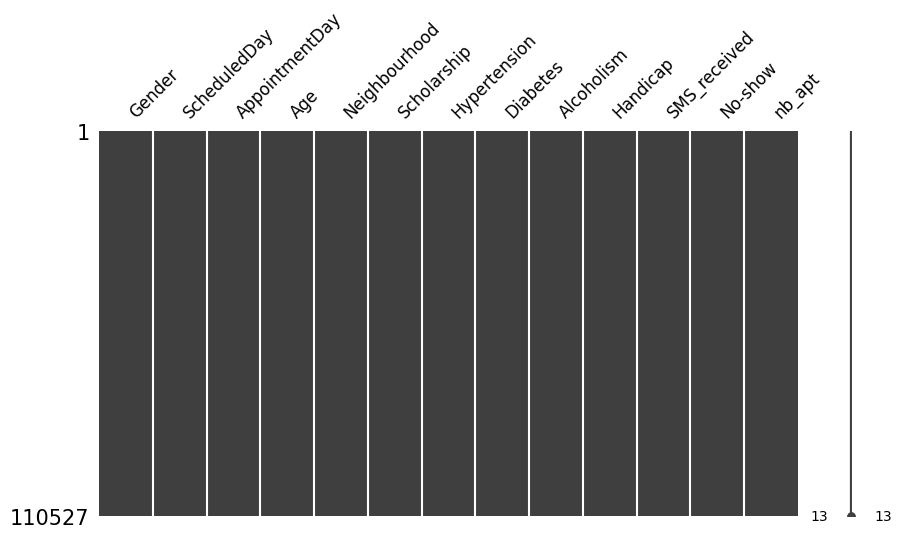

In [86]:
missingno.matrix(data,figsize=(10,5), fontsize=12);
plt.show()

In [87]:
data.tail(5)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,nb_apt
110522,F,2016-06-08T08:20:01Z,2016-06-08T00:00:00Z,41,MARIA ORTIZ,0,0,0,0,0,0,No,1
110523,M,2016-06-08T07:52:55Z,2016-06-08T00:00:00Z,2,ANTÔNIO HONÓRIO,0,0,0,0,0,0,No,1
110524,F,2016-04-27T15:15:06Z,2016-06-07T00:00:00Z,50,MARIA ORTIZ,0,0,0,0,0,1,No,1
110525,F,2016-05-03T07:51:47Z,2016-06-07T00:00:00Z,42,MARIA ORTIZ,0,0,0,0,0,1,No,1
110526,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No,1


In [88]:
cat_to_encode = ['Gender', 'Neighbourhood', 'No-show']
data = labelencode(data, cat_to_encode)

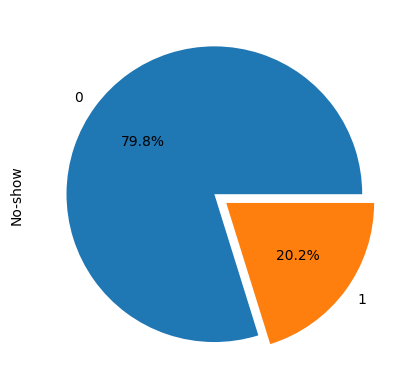

In [89]:
data['No-show'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%')
plt.show()

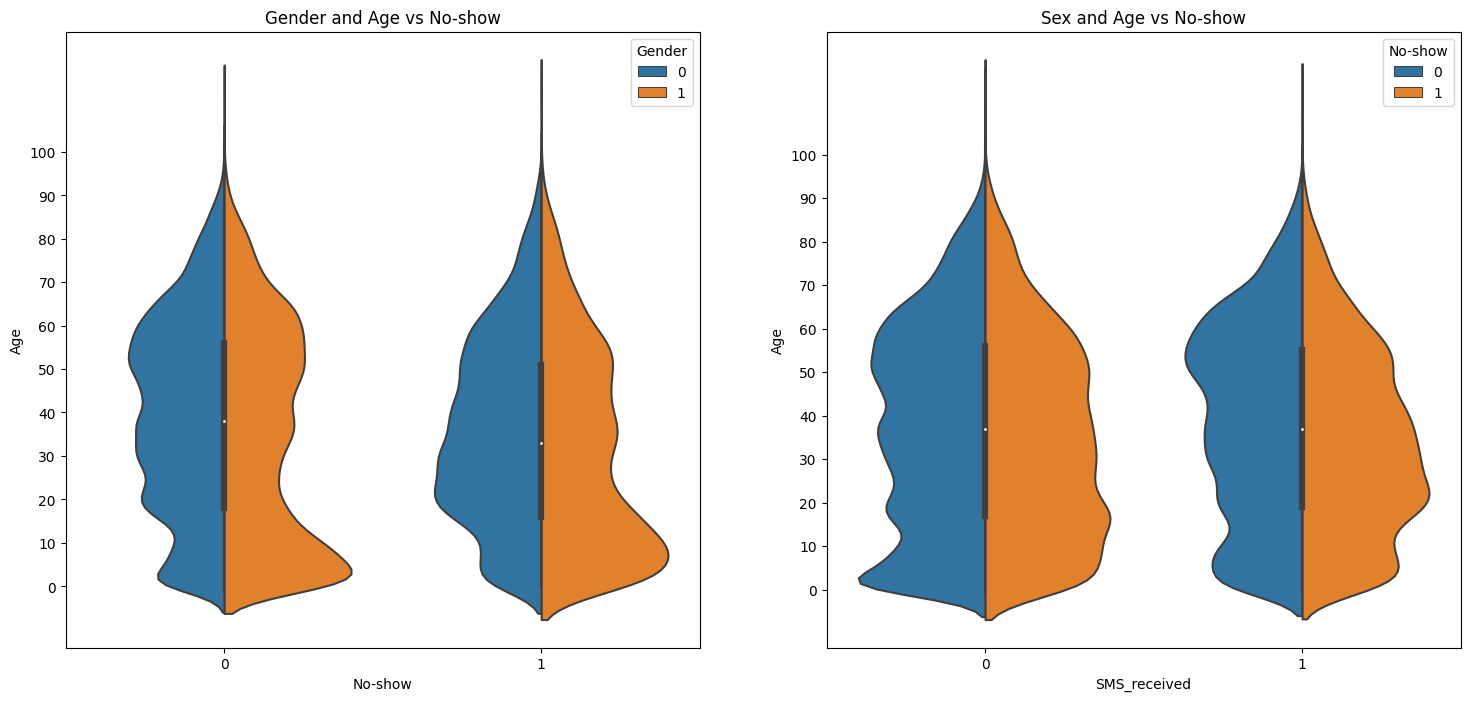

In [90]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("No-show","Age", hue="Gender", data=data,split=True,ax=ax[0])
ax[0].set_title('Gender and Age vs No-show')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("SMS_received","Age", hue="No-show", data=data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs No-show')
ax[1].set_yticks(range(0,110,10))
plt.show()

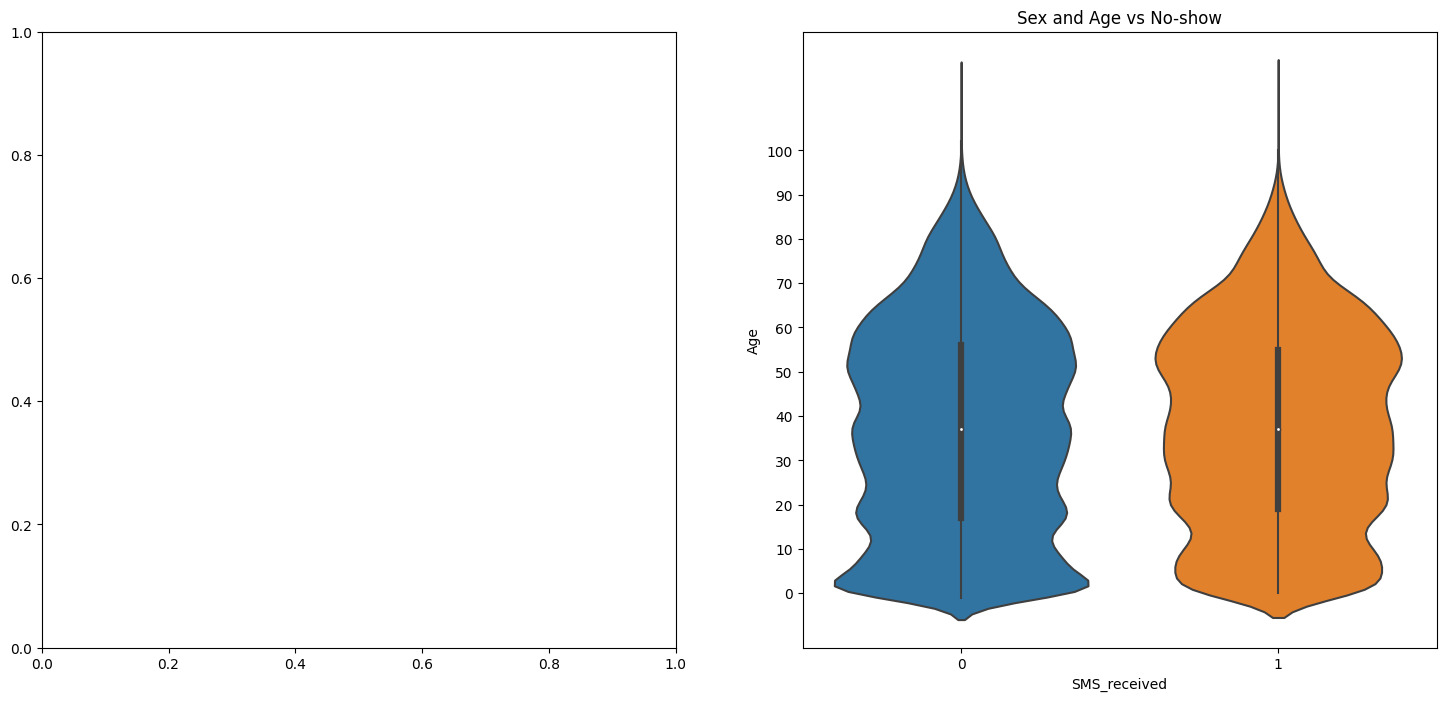

In [91]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("SMS_received","Age", data=data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs No-show')
ax[1].set_yticks(range(0,110,10))
plt.show()

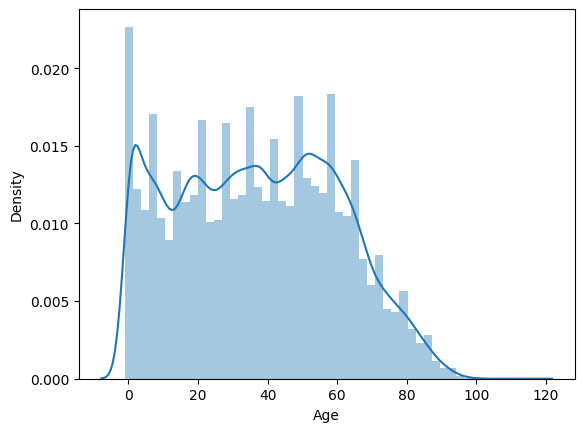

In [92]:
sns.distplot(data['Age'])
plt.show()


In [93]:
# segmenter age tous les 10
# jour , heure , minute cat 
# shap value + feature importance

In [94]:
fig, ax = plt.subplots()

sns.kdeplot(data[data["No-show"]==1]["Age"], shade=True, color="blue", label="survived", ax=ax)
sns.kdeplot(data[data["No-show"]==0]["Age"], shade=True, color="green", label="did not survive", ax=ax)

ax.set_xlabel("Age")
ax.set_ylabel("Density")

fig.suptitle("Age vs. Survival for Titanic Passengers")

Text(0.5, 0.98, 'Age vs. Survival for Titanic Passengers')

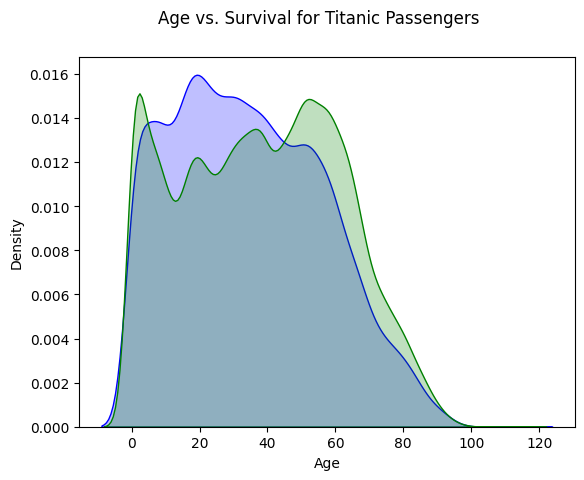

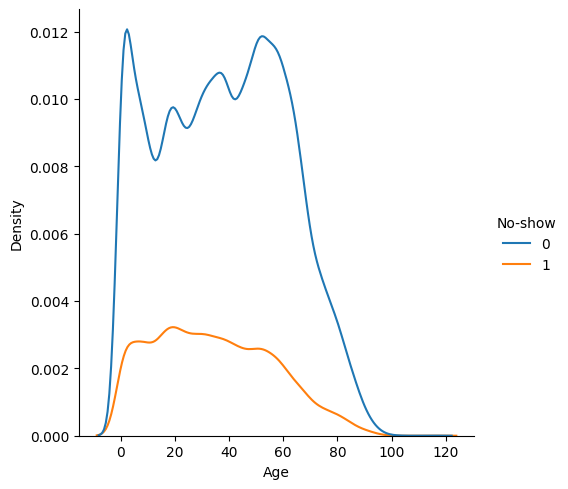

In [95]:
sns.displot(data, x="Age", hue="No-show", kind="kde")
plt.show()

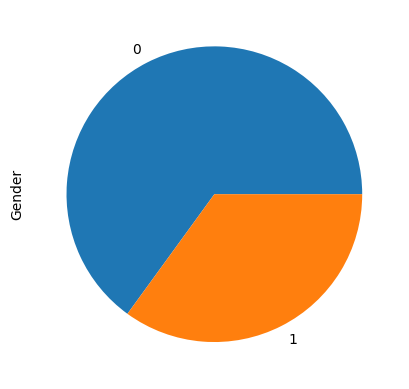

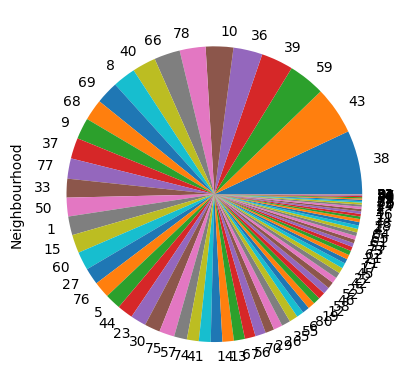

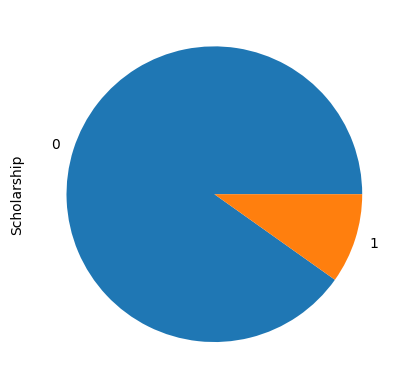

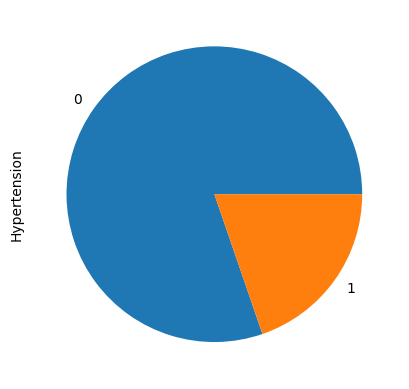

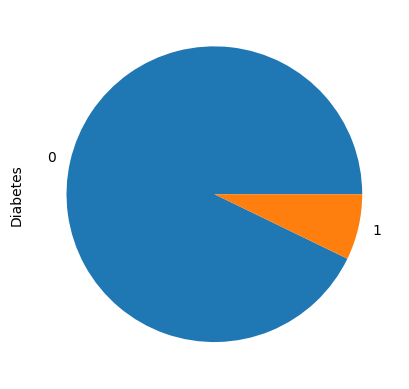

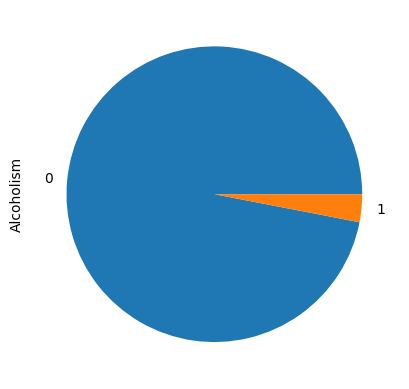

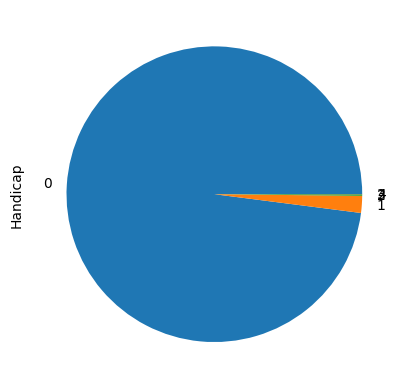

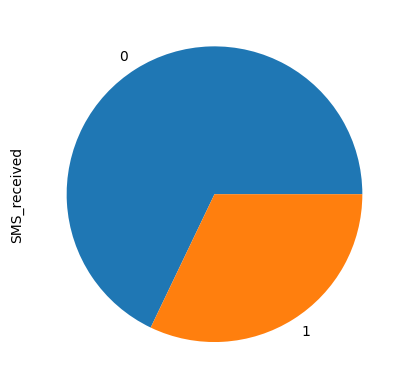

In [96]:
cat = ['Gender', 'Neighbourhood','Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received']
for c in cat:
    data[c].value_counts().plot.pie()
    plt.show()
#     sns.countplot(c,data=data)
#     plt.show()

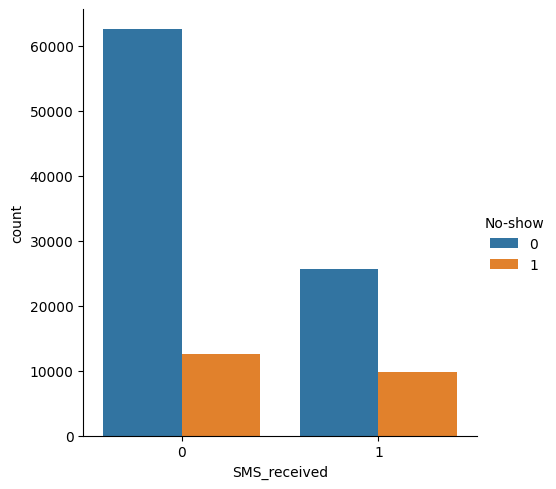

In [97]:
sns.catplot(x='SMS_received',data=data,kind='count',hue='No-show')
plt.show()

In [98]:
times_sch = get_date(data['ScheduledDay'], 'T')
times_apt = get_date(data['AppointmentDay'], 'T')

In [99]:
data = feature_engineering(data)

In [100]:
data

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,nb_apt,month_sch,day_sch,hour_sch,minute_sch,second_sch,month_apt,day_apt
0,0,62,39,0,1,0,0,0,0,0,2,4,29,18,38,8,4,29
1,0,62,39,0,1,0,0,0,0,0,2,4,29,9,47,47,4,29
2,1,56,39,0,0,0,0,0,0,0,2,4,29,16,8,27,4,29
3,1,56,39,0,0,0,0,0,0,0,2,4,29,15,20,47,4,29
4,0,62,45,0,0,0,0,0,0,0,2,4,29,16,19,4,4,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,0,41,43,0,0,0,0,0,0,0,1,6,8,8,20,1,6,8
110523,1,2,2,0,0,0,0,0,0,0,1,6,8,7,52,55,6,8
110524,0,50,43,0,0,0,0,0,1,0,1,4,27,15,15,6,6,7
110525,0,42,43,0,0,0,0,0,1,0,1,5,3,7,51,47,6,7


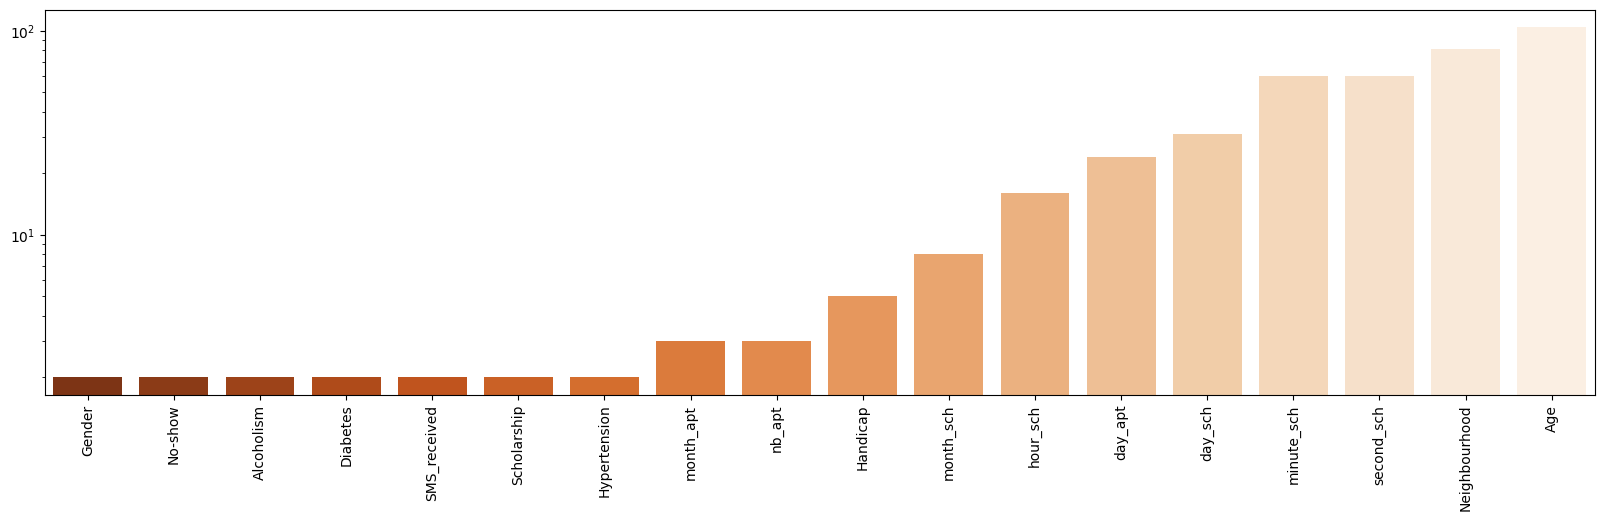

In [102]:
data = num_to_cat(data, max_unique_values=10)

Y = data['No-show']
X = data.drop('No-show', axis=1)

In [79]:
# Converting num feature to categorical

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.3, random_state=0, stratify=Y)

In [84]:
kpis, _, best_model, _ = train_classifier_lazy(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

 90%|█████████████▍ | 26/29 [2:16:27<1:57:12, 2344.24s/it]

[18:06:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████████████| 29/29 [2:16:40<00:00, 282.79s/it]


In [ ]:
kpis

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,matthews_corrcoef,Time Taken
Model,,,,,,
RandomForestClassifier,0.80,0.54,0.54,0.74,0.17,31.37
BaggingClassifier,0.79,0.56,0.56,0.75,0.17,14.33
ExtraTreesClassifier,0.80,0.54,0.54,0.74,0.16,36.30
NearestCentroid,0.61,0.60,0.60,0.65,0.16,1.00
DecisionTreeClassifier,0.72,0.58,0.58,0.72,0.15,3.18
XGBClassifier,0.80,0.53,0.53,0.74,0.14,11.67
ExtraTreeClassifier,0.71,0.56,0.56,0.72,0.13,1.35
KNeighborsClassifier,0.77,0.54,0.54,0.74,0.12,95.51
BernoulliNB,0.75,0.55,0.55,0.73,0.11,1.16


In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

categorical_transformer_low = Pipeline(
    steps=[
        ("encoding", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

numeric_transformer = Pipeline(
    steps=[
        
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", numeric_transformer, numeric_features),
                ("categorical_low", categorical_transformer_low, categorical_features),
            ]
        )

X = preprocessor.fit_transform(X)

In [65]:
model = RandomForestClassifier()

In [66]:
rf_params = {'criterion' : 'gini',
             'max_depth' : 8,
             'min_samples_leaf': 1,
            }

In [69]:
X.shape

(110527, 38)

In [70]:
Y

0         0
1         0
2         0
3         0
4         0
         ..
110522    0
110523    0
110524    0
110525    0
110526    0
Name: No-show, Length: 110527, dtype: object

In [77]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
for id_train, id_valid in tqdm.tqdm(folds.split(X=X, y=Y)):
    X_train, y_train = X.iloc[id_train], y.iloc[id_train]
    X_valid, y_valid = X.iloc[id_valid], y.iloc[id_valid]

0it [00:00, ?it/s]


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'unknown' instead.

In [104]:
train_kpis, valid_kpis = run_model(X, Y, params=rf_params, n_splits=5, random_state=12)

0it [00:00, ?it/s]


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'unknown' instead.

In [45]:
train_kpis

{'train_auc_fold_0': 0.500112013441613,
 'train_mcc_fold_0': 0.013371493914075511,
 'train_auc_fold_1': 0.5000280033604032,
 'train_mcc_fold_1': 0.0066856335358038465,
 'train_auc_fold_2': 0.5000280017921147,
 'train_mcc_fold_2': 0.006685408518725667,
 'train_auc_fold_3': 0.5000560067208065,
 'train_mcc_fold_3': 0.009454980612560577,
 'train_auc_fold_4': 0.5000280033604032,
 'train_mcc_fold_4': 0.006685643101065823}

In [46]:
valid_kpis

{'valid_auc_fold_0': 0.5,
 'valid_mcc_fold_0': 0.0,
 'valid_auc_fold_1': 0.5,
 'valid_mcc_fold_1': 0.0,
 'valid_auc_fold_2': 0.5,
 'valid_mcc_fold_2': 0.0,
 'valid_auc_fold_3': 0.5,
 'valid_mcc_fold_3': 0.0,
 'valid_auc_fold_4': 0.5,
 'valid_mcc_fold_4': 0.0}

In [43]:
import sklearn
from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.base import ClassifierMixin

import xgboost

import catboost
import lightgbm

CLASSIFIERS = [est for est in all_estimators() if issubclass(est[1], ClassifierMixin)]

CLASSIFIERS.append(("XGBClassifier", xgboost.XGBClassifier))
CLASSIFIERS.append(("LGBMClassifier", lightgbm.LGBMClassifier))

removed_classifiers = [
    ("CheckingClassifier", sklearn.utils._mocking.CheckingClassifier),
    ("ClassifierChain", sklearn.multioutput.ClassifierChain),
    ("ComplementNB", sklearn.naive_bayes.ComplementNB),
    (
        "GradientBoostingClassifier",
        sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
    ),
    (
        "GaussianProcessClassifier",
        sklearn.gaussian_process.gpc.GaussianProcessClassifier,
    ),
    (
        "HistGradientBoostingClassifier",
        sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier,
    ),
    ("MLPClassifier", sklearn.neural_network.multilayer_perceptron.MLPClassifier),
    ("LogisticRegressionCV", sklearn.linear_model.logistic.LogisticRegressionCV),
    ("MultiOutputClassifier", sklearn.multioutput.MultiOutputClassifier),
    ("MultinomialNB", sklearn.naive_bayes.MultinomialNB),
    ("OneVsOneClassifier", sklearn.multiclass.OneVsOneClassifier),
    ("OneVsRestClassifier", sklearn.multiclass.OneVsRestClassifier),
    ("OutputCodeClassifier", sklearn.multiclass.OutputCodeClassifier),
    ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
    (
        "RadiusNeighborsClassifier",
        sklearn.neighbors.classification.RadiusNeighborsClassifier,
    ),
    ('SVC', sklearn.svm._classes.SVC),
    ("VotingClassifier", sklearn.ensemble.voting.VotingClassifier),
]

In [44]:
for clf in removed_classifiers:
    CLASSIFIERS.pop(CLASSIFIERS.index(clf))

CLASSIFIERS.append(("XGBClassifier", xgboost.XGBClassifier))
CLASSIFIERS.append(("LGBMClassifier", lightgbm.LGBMClassifier))
CLASSIFIERS.append(('CatBoostClassifier',catboost.CatBoostClassifier))

In [53]:
CLASSIFIERS = [est for est in all_estimators() if issubclass(est[1], ClassifierMixin)]

In [40]:
from lazypredict.Supervised import LazyClassifier

In [54]:
clf = LazyClassifier(classifiers=CLASSIFIERS)
models, prediction = clf.fit(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

100%|█████████████████████████████| 42/42 [00:00<?, ?it/s]


In [55]:
print(models)

Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []


In [51]:
print(models)

Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []


In [45]:
kpis, _, best_model, _ = train_classifier_lazy(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, classifiers=CLASSIFIERS)

100%|██████████████████| 30/30 [00:00<00:00, 30023.65it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [56]:
temp_list = []
for classifier in CLASSIFIERS:
    full_name = (classifier.__class__.__name__, classifier)
    temp_list.append(full_name)

In [57]:
temp_list

[('tuple',
  ('AdaBoostClassifier',
   sklearn.ensemble._weight_boosting.AdaBoostClassifier)),
 ('tuple', ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier)),
 ('tuple', ('BernoulliNB', sklearn.naive_bayes.BernoulliNB)),
 ('tuple',
  ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV)),
 ('tuple', ('CategoricalNB', sklearn.naive_bayes.CategoricalNB)),
 ('tuple', ('CheckingClassifier', sklearn.utils._mocking.CheckingClassifier)),
 ('tuple', ('ClassifierChain', sklearn.multioutput.ClassifierChain)),
 ('tuple', ('ComplementNB', sklearn.naive_bayes.ComplementNB)),
 ('tuple',
  ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier)),
 ('tuple', ('DummyClassifier', sklearn.dummy.DummyClassifier)),
 ('tuple', ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier)),
 ('tuple',
  ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier)),
 ('tuple', ('GaussianNB', sklearn.naive_bayes.GaussianNB)),
 ('tuple',
  ('Gaus